# [Modelo] Sistema Recomendador

#### Caso:

El caso consiste que hoy endia muchas entidades bancarias suelen gestionar sus campañas en base a cluster, sin embargo, apereció una necesidad en realizar campañas más personalizadas, donde a un grupo de clientes de un mismo cluster no necesariamente les puede gustar algunos decuentes que se les ofrece en común.

Por tanto, se pide desarrollar un sistema recomendador a nivel de establecimientos comerciales (nivel más a detalle) para los clientes que consumen con sus tarjetas de crédito y/o débito.

### 1. Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
plt.style.use('ggplot')
pd.options.display.max_columns = None #Para que se visualicen todas las variables
import os

### 2. Extracción Base de datos

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


[Caso Aplicativo](https://colab.research.google.com/drive/1let-Wz3_vZsy9XX-Gr6J0F3X-JI5stlT#scrollTo=j9dJPinNrW_g)

[Pizarra](https://docs.google.com/spreadsheets/d/1zWmT5NRwoEmbY99DsT3O-fBXCiT3Hb-5lUevuPZMwnw/edit#gid=53783739)

In [3]:
#Repositorios
path = '/gdrive/MyDrive/BQ - Data Science/BQ - Repositorios/DMC/Machine Learning/ML No Supervisado'
filename = "03dataBaseRecom.txt"
fullpath = os.path.join(path, filename)

In [4]:
dataFramePre = pd.read_csv(fullpath,delimiter='|', encoding='latin-1')
print(dataFramePre.head())

   codmes  cliente  codComercio       edad      ingreso grupoGiro  \
0  201611     6545          518  [2. <=30]  [4. <=3500]   restbar   
1  201701      534         6919  [7. > 55]  [4. <=3500]   restbar   
2  201611     7725         1032  [1. <=25]  [2. <=1500]   restbar   
3  201701     5215          518  [5. <=45]  [3. <=2500]   restbar   
4  201611      695         4486  [6. <=55]  [4. <=3500]   restbar   

          comercio             distEstab     direcestab  monto  trx  
0  00000518kfc 106                  lima  00000518cabo      33    1  
1  00006919la anto     magdalena del mar  00006919juan      39    1  
2  00001032bembos          independencia  00001032alfre     12    1  
3  00000518kfc 106                  lima  00000518cabo      39    1  
4  00004486mc dona  san juan de luriganc  00004486proce     31    1  


In [5]:
dataFramePre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111725 entries, 0 to 111724
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   codmes       111725 non-null  int64 
 1   cliente      111725 non-null  int64 
 2   codComercio  111725 non-null  int64 
 3   edad         107142 non-null  object
 4   ingreso      101073 non-null  object
 5   grupoGiro    111725 non-null  object
 6   comercio     111725 non-null  object
 7   distEstab    111725 non-null  object
 8   direcestab   111725 non-null  object
 9   monto        111725 non-null  int64 
 10  trx          111725 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 9.4+ MB


### 3. Metodología

In [6]:
#### 3.1 Construcción de DataSet (objetivo)
#### 3.2 Análisi Previo
#### 3.3 Asignación de Puntuación
#### 3.4 Muestra Training - Testing
#### 3.5 Mdelamiento
#### 3.6 Evaluación
#### 3.7 Resultados
#### 3.8 Información de Gestión

#### 3.1 Construcción Data Set

In [7]:
# ---------------------------------------
# Construcción de Data Set [User - Item]
# ---------------------------------------

# Base de datos suma de monto y trx total por cliente:
copy = pd.DataFrame()
copy = dataFramePre.copy()
tempMontoTot = pd.DataFrame()
tempMontoTot['montoTot'] = copy.groupby('cliente').agg('monto').sum()
tempMontoTot['trxTot'] = copy.groupby('cliente').agg('trx').sum()
tempMontoTot = tempMontoTot.reset_index()
tempMontoTot.head(3)

,cliente,montoTot,trxTot
0,1,81,9
1,2,17315,167
2,3,401,5


In [8]:
# Base de datos suma de monto y trx total por cliente y comercio:
copy = pd.DataFrame()
copy = dataFramePre.copy()
tempMontoComercio = pd.DataFrame()
tempMontoComercio['montoComercio'] = copy.groupby(['cliente','codComercio']).agg('monto').sum()
tempMontoComercio['trxComercio'] = copy.groupby(['cliente','codComercio']).agg('trx').sum()
tempMontoComercio = tempMontoComercio.reset_index()
tempMontoComercio.head(3)

,cliente,codComercio,montoComercio,trxComercio
0,1,5529,81,9
1,2,24,9,1
2,2,26,197,1


In [9]:
print('****************************')
print('  Dimensiones User - Item')
print('****************************')

cliUn = tempMontoTot.shape[0]
comUn = tempMontoComercio['codComercio'].drop_duplicates().shape[0]
dimDb = tempMontoComercio.shape
print('1. Clientes únicos: '+str(cliUn))
print('2. Comercios únicos: '+str(comUn))
print('3. DataSet Cliente X Comercio: '+str(dimDb)+'\n')
print(tempMontoComercio.columns)

****************************
  Dimensiones User - Item
****************************
1. Clientes únicos: 10483
2. Comercios únicos: 17618
3. DataSet Cliente X Comercio: (79179, 4)

Index(['cliente', 'codComercio', 'montoComercio', 'trxComercio'], dtype='object')


In [10]:
# ------------------------
# Construyendo el Ranking
# ------------------------

In [11]:
## Cálculo de Peso del userXitem en base al monto y transacción por cliente - comercio:
dbMerge = pd.merge(tempMontoComercio, tempMontoTot, on = 'cliente', how = 'left')
dbMerge['preRating'] = (dbMerge['montoComercio']/dbMerge['montoTot'])*(dbMerge['trxComercio']/dbMerge['trxTot'])
dbMerge.head()

,cliente,codComercio,montoComercio,trxComercio,montoTot,trxTot,preRating
0,1,5529,81,9,81,9,1.000000
1,2,24,9,1,17315,167,0.000003
2,2,26,197,1,17315,167,0.000068
3,2,74,51,1,17315,167,0.000018
4,2,87,329,3,17315,167,0.000341


In [12]:
# Creación del "Rating Final" a una escala de [0-1]
copy = pd.DataFrame()
copy = dbMerge.copy()
tempRatingTot = pd.DataFrame()

tempRatingTot['sumaPreRat'] = copy.groupby('cliente').agg('preRating').sum()
tempRatingTot = tempRatingTot.reset_index()
tempRatingTot.head()

,cliente,sumaPreRat
0,1,1.000000
1,2,0.197372
2,3,0.200000
3,4,0.158730
4,5,0.069414


In [13]:
# Unico rating
dataBaseInputPre = pd.merge(dbMerge, tempRatingTot, on='cliente', how='left')
# Con esto se garanztiza que el rating va de 0 a 1 para todos los clientes
dataBaseInputPre['rating'] = dataBaseInputPre['preRating']/dataBaseInputPre['sumaPreRat']
dataBaseInputPre.head()

,cliente,codComercio,montoComercio,trxComercio,montoTot,trxTot,preRating,sumaPreRat,rating
0,1,5529,81,9,81,9,1.000000,1.000000,1.000000
1,2,24,9,1,17315,167,0.000003,0.197372,0.000016
2,2,26,197,1,17315,167,0.000068,0.197372,0.000345
3,2,74,51,1,17315,167,0.000018,0.197372,0.000089
4,2,87,329,3,17315,167,0.000341,0.197372,0.001729


In [14]:
# Base de Datos Final de Recomendación:
dataBaseInputPre = dataBaseInputPre[['cliente','codComercio','rating']]
dataBaseInputPre = dataBaseInputPre.sort_values('cliente')
dataBaseInputPre.head()

,cliente,codComercio,rating
0,1,5529,1.000000
20,2,2369,0.909338
21,2,2660,0.000105
22,2,2692,0.000112
23,2,2695,0.000887


#### 3.2 Análisis Previo

In [15]:
# hay clientes que en un año solo ha visitado un comercio
# hay comercios que en un año solo fue visitado por pocos clientes (<50)

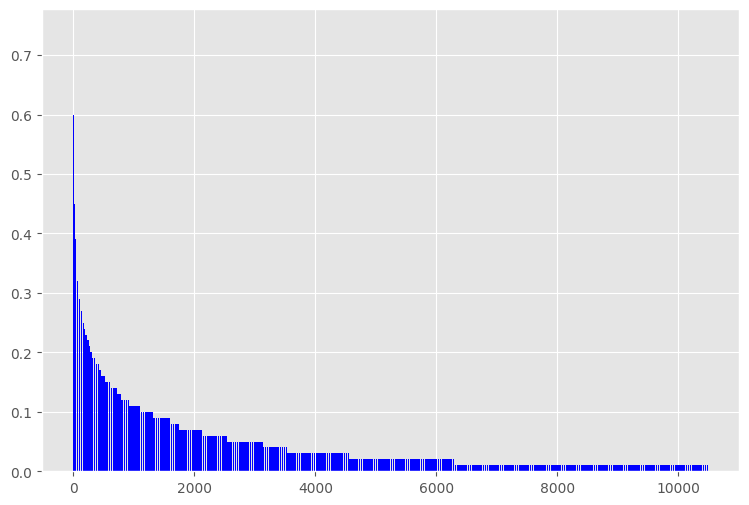

In [16]:
copy = pd.DataFrame()
copy = dataBaseInputPre.copy()
indCliente = pd.DataFrame()

indCliente['ctdComer'] = copy.groupby('cliente').size()
indCliente['pctComer'] = round(100*indCliente['ctdComer']/comUn,2)
indCliente = indCliente.sort_values('pctComer', ascending=False)

plt.bar(range(len(indCliente.index)),indCliente['pctComer'],color='blue')
plt.show()

In [17]:
# Existen cerca de 4mil clientes que el porcentaje de comercios es muy bajo (<0.05)
# Podriamos considerar de 0 a 6mil

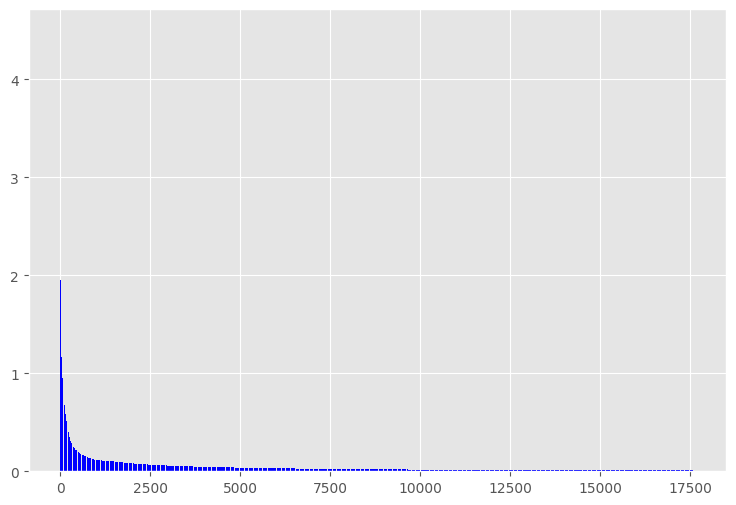

In [18]:
copy = pd.DataFrame()
copy = dataBaseInputPre.copy()
indComer = pd.DataFrame()

indComer['ctdCli'] = copy.groupby('codComercio').size()
indComer['pctCli'] = round(100*indComer['ctdCli']/cliUn,2)
indComer = indComer.sort_values('pctCli', ascending=False)

plt.bar(range(len(indComer.index)),indComer['pctCli'],color='blue')
plt.show()

In [19]:
# hay una gran cantidad de comercios que casi nadie los esta visitando

Dado los gráficos, elegimos los filtros de clientes y comercios de IMPORTANCIA para mi análisis

In [20]:
# Filtro de Clientes:
filCli = indCliente[indCliente['pctComer']>=0.025].reset_index()
filCli = filCli['cliente']
# Filtro de Comercios:
filComer = indComer[indComer['pctCli']>=0.025].reset_index()
filComer = filComer['codComercio']

print('Clientes únicos: '+str(filCli.shape[0]))
print('Comercios únicos: '+str(filComer.shape[0]))

Clientes únicos: 4558
Comercios únicos: 6540


Acotamos nuestra base de datos luego de determinar nuestros filtros para las categorías: "User" - "Items"

In [21]:
dataBaseInput = dataBaseInputPre[dataBaseInputPre['cliente'].isin(list(filCli))]
dataBaseInput = dataBaseInput[dataBaseInput['codComercio'].isin(list(filComer))]
print('Dimensión del Dataset Final: '+str(dataBaseInput.shape[0])+'\n')
dataBaseInput.head()

Dimensión del Dataset Final: 55454



,cliente,codComercio,rating
20,2,2369,0.909338
21,2,2660,0.000105
22,2,2692,0.000112
23,2,2695,0.000887
25,2,4404,0.002066


#### 3.3 Asignación de puntuación:

In [22]:
# En base a la frecuencia user - item puntuará con una etiqueta (categórica)
dbInputFinal = dataBaseInput

copy = pd.DataFrame()
copy = dbInputFinal.copy()

dbInputFinal['cliente'] = copy['cliente'].astype("category")
dbInputFinal['codComercio'] = copy['codComercio'].astype("category")

dbInputFinal['clienteId'] = dbInputFinal['cliente'].cat.codes
dbInputFinal['codComercioId'] = dbInputFinal['codComercio'].cat.codes
dbInputFinal.head()

,cliente,codComercio,rating,clienteId,codComercioId
20,2,2369,0.909338,0,1343
21,2,2660,0.000105,0,1498
22,2,2692,0.000112,0,1515
23,2,2695,0.000887,0,1516
25,2,4404,0.002066,0,2486


In [23]:
# El cliente 2 se repite mas veces que el resto, por ello se le asigno el id 0
# el comercio 2369 (entre todos los comercios) tiene la posicion 1343

#### 3.4 Muestra Training - Testing

In [24]:
# Training - Testing:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dbInputFinal, test_size=0.3)
# reseteamos los índices:
train = train.reset_index()
test = test.reset_index()

In [25]:
train.head()

,index,cliente,codComercio,rating,clienteId,codComercioId
0,10952,1155,4828,0.007062,559,2694
1,4039,415,1161,0.004041,197,696
2,54604,6496,627,0.061375,3010,438
3,74712,9405,13623,0.414513,4260,6073
4,7309,747,4410,0.029994,361,2489


#### 3.5 Modelamiento

In [26]:
!pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 65.5 MB/s eta 0:00:00


In [27]:
# En caso no tenga la  version Visual C++ mayor a 14.0, descargar en: https://visualstudio.microsoft.com/visual-cpp-build-tools/
# python -m pip install --user --upgrade pip (en caso la versión "pip" no sea mayor o igual a 18.0)
# Debemos importar el package "implicit" en el Terminal de la notebook
# python -m pip install implicit
import scipy.sparse as sparse
import implicit

In [28]:
# Convertimos nuestra base de datos en matriz tipo "sparse"
dbUserItem = sparse.csr_matrix((train['rating'],(train['clienteId'],train['codComercioId'])))
dbItemUser = sparse.csr_matrix((train['rating'],(train['codComercioId'],train['clienteId'])))

In [29]:
dbUserItem

<4557x6527 sparse matrix of type '<class 'numpy.float64'>'
	with 38817 stored elements in Compressed Sparse Row format>

In [30]:
dbItemUser

<6527x4557 sparse matrix of type '<class 'numpy.float64'>'
	with 38817 stored elements in Compressed Sparse Row format>

In [31]:
users_items = dbItemUser.T.tocsr()

In [32]:
users_items

<4557x6527 sparse matrix of type '<class 'numpy.float64'>'
	with 38817 stored elements in Compressed Sparse Row format>

In [33]:
# Convertimos en lista combinada a nuestro "User vs Item"
lista = []
for i in range(train.shape[0]):
    temp = [train.loc[i,'clienteId'],train.loc[i,'codComercioId']]
    lista.append(temp)

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

# Extraemos la predicción de la combinación "User vs Item"
alpha= 100     # Dara mayor puntuacion (peso) a los pares (usuario-comercio) que tengan valor
# Esto podra identificar por cada cliente los comercios que frecuenta (asignandole un peso) mientras que los comercios que no frecuenta
# los va  adejar vacio, esto para que cuando haga la recomendacion, se enfoque en aquellos comercios que no ha frecuentado.
rmse = [0.0]
difRmse = [0.0]
for numIter in range(1,8):
    pred = []
    model = implicit.als.AlternatingLeastSquares(factors=10, regularization=0.0001, iterations=numIter)
    model.fit(dbItemUser*alpha)

    for item, user in lista:
        #valor = model.explain(item,users_items,user)
        valor = model.recommend(item,users_items,N=user)
        pred.append(valor[0])

    rating = list(train['rating'])
    calrmse = sqrt(mean_squared_error(rating,pred))
    dif = abs(calrmse-rmse[numIter-1])
    rmse.append(calrmse)
    difRmse.append(dif)

    print('Nro Iteración: '+str(numIter))
    print('Dif-RMSE: '+str(dif)+'   RMSE: '+str(calrmse))

# Gráfico de RMSE:
plt.plot(rmse[1:])
plt.title("Evolutivo RMSE")
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

ValueError: ignored

In [37]:
# Nos quedamos con el que tenga menor Error Cuadratico Medio

#### 3.6 Evaluación

In [38]:
numIter = int(input('El número de iteraciones es: '))
model = implicit.als.AlternatingLeastSquares(factors=10, regularization=0.0001, iterations=numIter)
model.fit(dbItemUser*alpha)

El número de iteraciones es: 5


  0%|          | 0/5 [00:00<?, ?it/s]

In [41]:
# Convertimos en lista combinada a nuestro "User vs Item"
def evaluateRecom(df,model):
    lista = []
    pred = []
    for i in range(df.shape[0]):
        temp = [df.loc[i,'clienteId'],df.loc[i,'codComercioId']]
        lista.append(temp)

    for item, user in lista:
        #valor = model.explain(item,users_items,user)
        valor = model.recommend(item,users_items,user)
        pred.append(valor[0])

    rating = list(df['rating'])
    calrmse = sqrt(mean_squared_error(rating,pred))
    calmse = mean_squared_error(rating,pred)
    return calrmse, calmse, pred

In [42]:
print("********************************")
print("          Evaluación")
print("********************************")
print(" ")
print("* Indicador Predicción Training:")
rsme, mse, pred = evaluateRecom(train,model)
print('Root-mean-square error (RMSE) = '+str(rsme))
print('Mean-square error (MSE) = '+str(mse))
print(" ")
print("* Indicador Predicción Testing:")
rsme, mse, pred = evaluateRecom(test,model)
print('Root-mean-square error (RMSE) = '+str(rsme))
print('Mean-square error (MSE) = '+str(mse))
print(" ")
print("Predicciones basados en la base de datos de test:")
test['prediction'] = pd.DataFrame(pred)
test.head()

********************************
          Evaluación
********************************
 
* Indicador Predicción Training:


ValueError: ignored

#### 3.7 Resultados

In [43]:
numRec = int(input('¿Cuántas recomendaciones desea?: '))

¿Cuántas recomendaciones desea?: 5


In [44]:
clientes = set(list(dbInputFinal['clienteId']))
user = []
recom = []

for i in clientes:
    recommendations = model.recommend(i, users_items,N=numRec)
    user = user + numRec*[i]
    recom = recom + recommendations

df = pd.DataFrame()
df[['clienteId']]=pd.DataFrame(user)
df[['codComercioId',"score"]]=pd.DataFrame(recom)
df.head()

ValueError: ignored

#### 3.8 Información de Gestión

In [ ]:
# Importante: las variables no deben tener formato "categoría"
# Base de Datos de Recomendaciones:

clienteOrig = dbInputFinal[['clienteId','cliente']].drop_duplicates()
clienteOrig['cliente'] = clienteOrig['cliente'].astype('int')
comerOrig = dbInputFinal[['codComercioId','codComercio']].drop_duplicates()
comerOrig['codComercio'] = comerOrig['codComercio'].astype('int')
dataComer = dataFramePre[['codComercio','grupoGiro','comercio','direcestab']].drop_duplicates()

dbOuputFinal = pd.DataFrame()
dbOuputFinal = pd.merge(df,clienteOrig, on = 'clienteId', how='left')
dbOuputFinal = pd.merge(dbOuputFinal,comerOrig, on = 'codComercioId', how='left')
dbOuputFinal = pd.merge(dbOuputFinal,dataComer, on = 'codComercio', how='left')
dbOuputFinal = dbOuputFinal[['cliente','codComercio','grupoGiro','comercio','direcestab','score']]

print('\n*********************************************')
print('        NUEVO SISTEMA RECOMENDADOR - DMC' )
print('          Establecimientos Comerciales')
print('*********************************************')

dbOuputFinal.head()

In [ ]:
# Consulta de consumo Original:
cliente= 2

consulta = pd.merge(dataBaseInputPre,dataComer, on='codComercio',how='left')
consulta = consulta[consulta['cliente']==cliente].sort_values('rating',ascending=False)
consulta.head()